In [20]:
%matplotlib inline

import scipy.io as sio
import numpy as np
from nilearn import plotting 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from fctools import networks, figures


In [2]:
top_dir = '/home/finc/Dropbox/Projects/LearningBrain/data/neuroimaging/'
out_dir = '/home/finc/Dropbox/Projects/LearningBrain/github/LearningBrain_networks/figures/'
mat = sio.loadmat('/home/finc/Dropbox/Projects/LearningBrain/data/neuroimaging/multilayer_results_1/module_assignment.mat')
module_assignment = mat['modules']
module_assignment.shape

(46, 4, 264, 20)

Calculate module allegiance for each subject and session
------------------------------------------------------------------

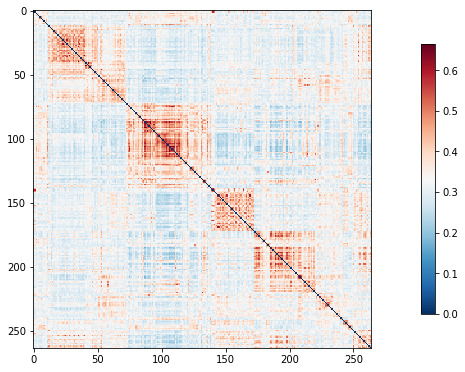

In [3]:
#--- calculate module allegiance
AM = networks.allegiance_matrices_4d(module_assignment)

AMm = AM.mean(axis = 0)
plotting.plot_matrix(AMm[3,:,:])

Getting modules names and color pallete
----------------------------------------

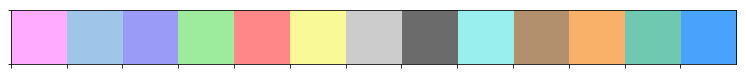

In [4]:
labels = pd.read_csv('/home/finc/Dropbox/Projects/LearningBrain/github/LearningBrain_networks/support/modules.txt', sep = " ", header = None)

power_colors = ['#ff00ff', '#9fc5e8', '#9900ff', '#00ff00', '#ff0000', '#ffff00', '#cccccc', '#000000', 
                '#00ffff', '#980000', '#ff9900', '#209675', '#0000ff']

power_colors_pastel = ['#FFABFF', '#9fc5e8', '#9A9AF7', '#9DEC9D', '#FF8787', '#F9F998', '#cccccc', '#6B6B6B', '#99EEEE',
                '#B3906D','#F9B068', '#6EC9B0', '#49A3FD']

modules = sorted(labels[0].values)
network_pal = (sns.color_palette(power_colors_pastel))

network_lut = dict(zip(map(str, np.unique(modules)), network_pal))
sns.palplot(sns.color_palette(power_colors_pastel))

network_colors = pd.Series(modules).map(network_lut)
network_colors = network_colors.tolist()

Sorting nodes in alphabetical order
---------------------------------------

In [5]:
# sorting labels and storing index
idx = np.argsort(labels[0])
AMsort = networks.sort_matrices_4d(AM, idx)

Plotting allegiance matrices
---------------------------------

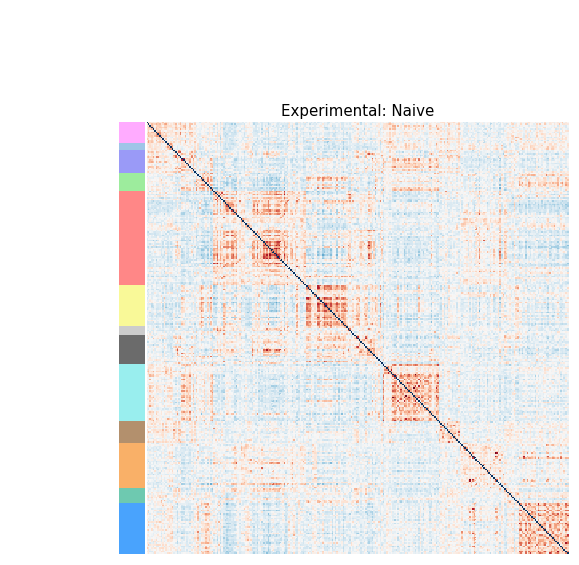

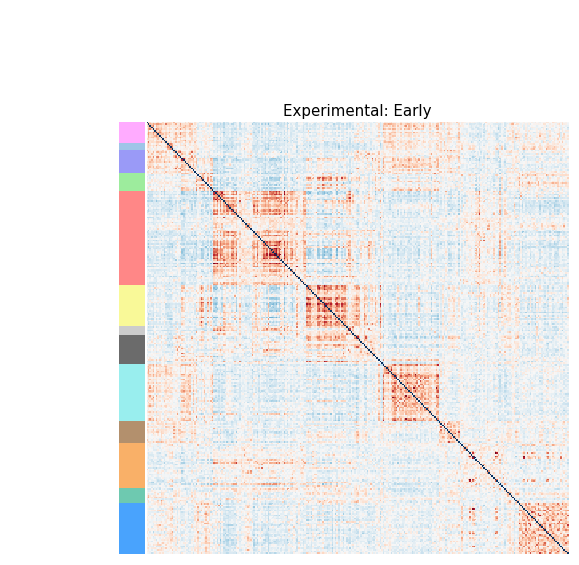

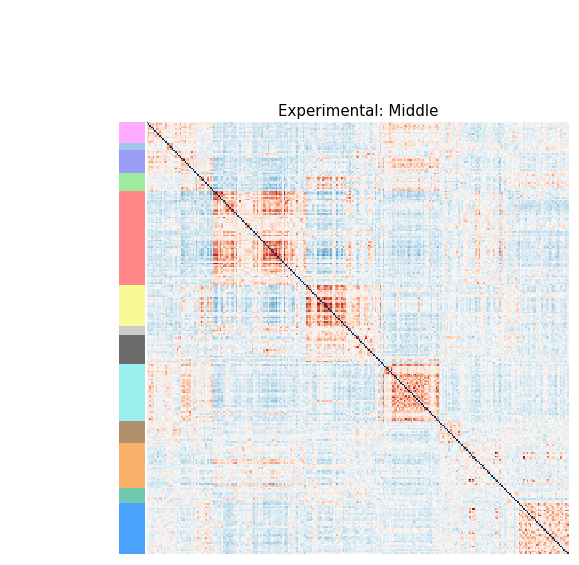

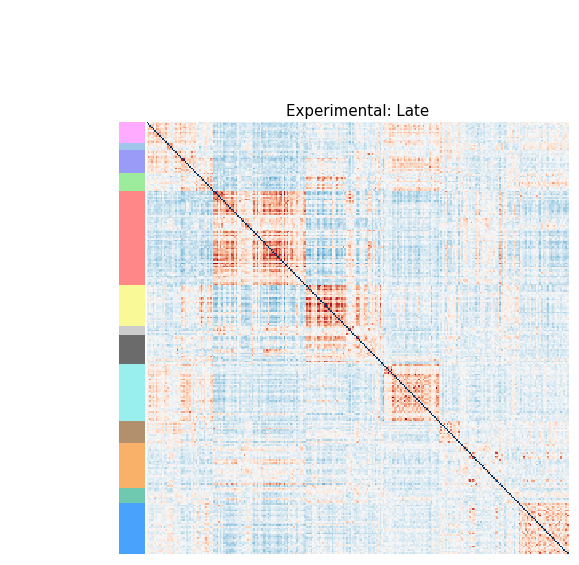

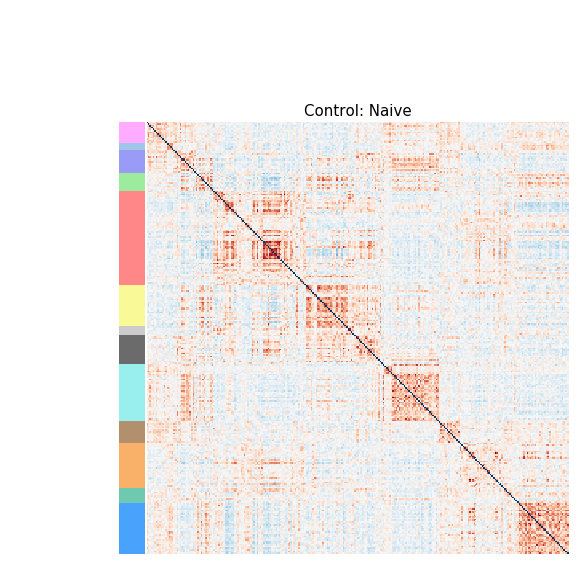

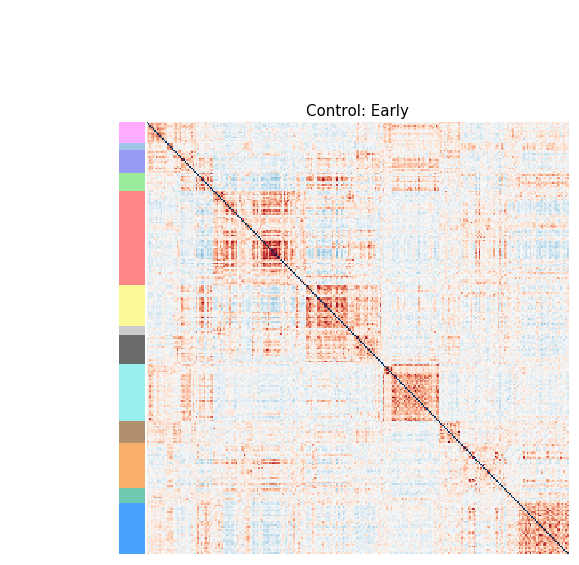

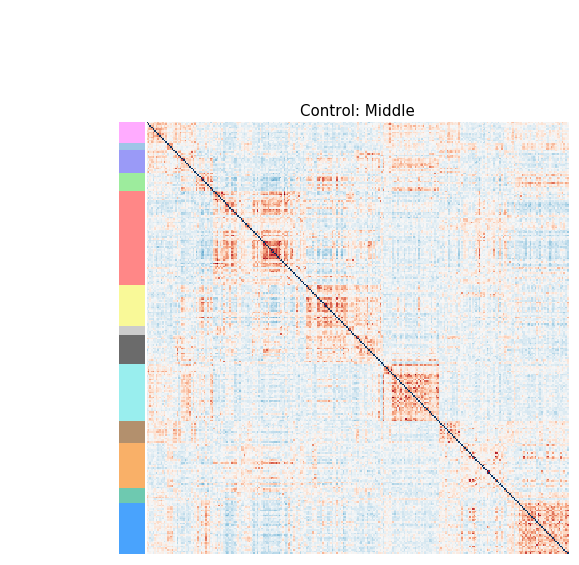

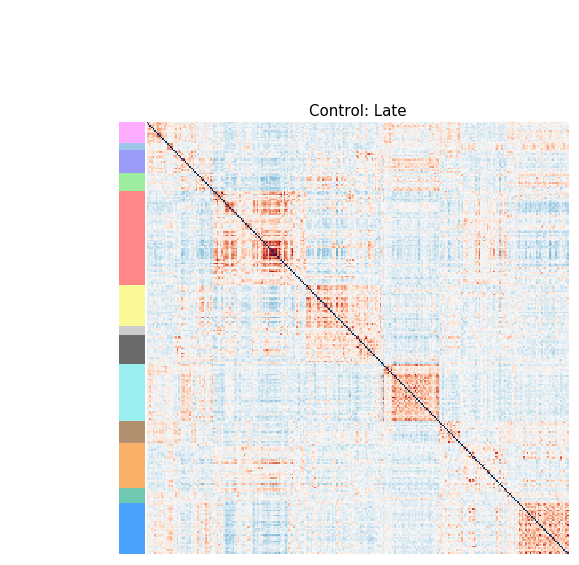

In [6]:
#-- selecting subjects who finished the study

groups = pd.read_csv('/home/finc/Dropbox/Projects/LearningBrain/data/behavioral/group_assignment.csv')

trained = (groups.group == 'Experimental') | (groups.group == 'Control')
trained_subs = groups[trained]

#--- creating vectors to filter by group
experimental = (trained_subs == 'Experimental')
control = (trained_subs == 'Control')

exp_vector = experimental['group'].values
con_vector = control['group'].values

group_vectors = [exp_vector, con_vector]
ses_lab = ['Naive', 'Early', 'Middle', 'Late']
group_lab = ['Experimental', 'Control']

#--- generating matrix plots with colors for each network
for i, vec in enumerate(group_vectors):
    for j, ses in enumerate(ses_lab):
        M = AMsort[vec, j, :, :].mean(axis = 0)
        figures.matrix_networks_plot(M, network_colors, dpi = 100, colorbar = False, group = group_lab[i], ses = ses, suffix = None, out_dir = out_dir)


Making grid plot with mean allegiances between/within systems
----------------------------------------------------------------

In [7]:
#--- calculate recruitment/integration grouped by distnct networks
NA = networks.fc_cartography_4d(AMsort, modules)
NA.shape

(46, 4, 13, 13)

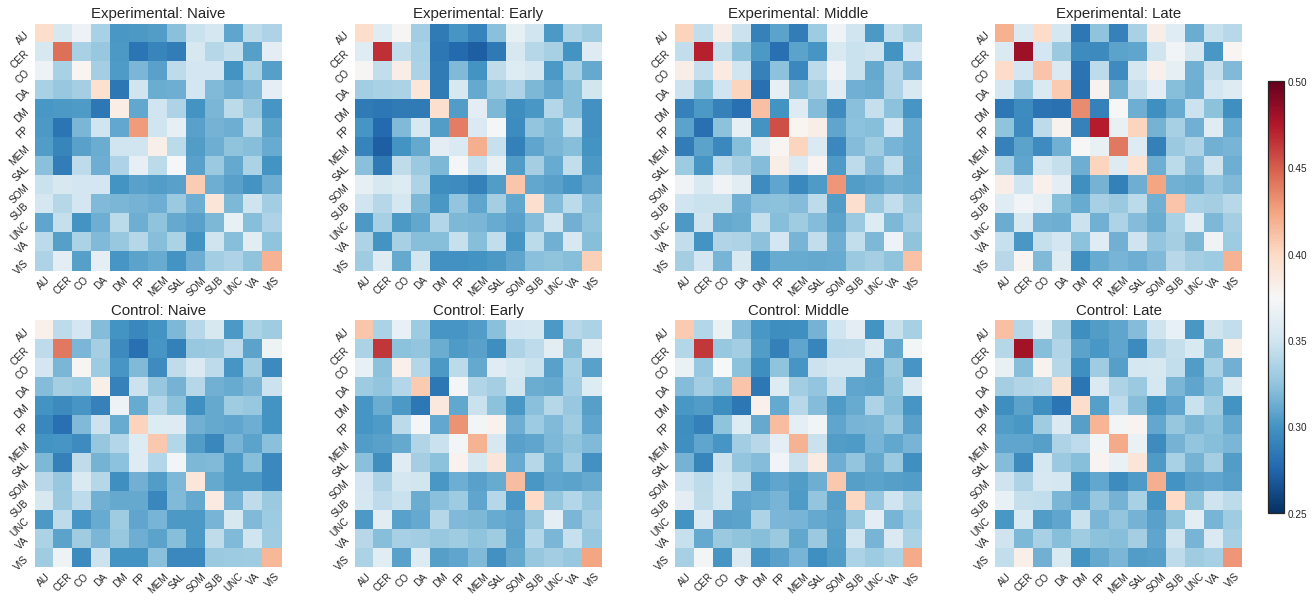

In [12]:
#--- plotting mean allegiances grouped by distinct networks

plt.style.use('seaborn-white')
fig, axes = plt.subplots(2, 4)
fig.set_size_inches(22, 10)
group_vectors = [exp_vector, con_vector]
ses_lab = ['Naive', 'Early', 'Middle', 'Late']
group_lab = ['Experimental', 'Control']

for i, vec in enumerate(group_vectors):
    for j, ses in enumerate(ses_lab):
        M = NA[vec,j, :,:].mean(axis=0)
        plt.ioff()
        g = sns.heatmap(M, yticklabels = np.unique(modules), 
                        xticklabels = np.unique(modules), 
                        square = True, 
                        cmap = "RdBu_r", 
                        ax=axes[i][j],
                        vmin = 0.25, vmax = 0.50,
                        cbar=None)
        g.set_title(f'{group_lab[i]}: {ses}', size = 15)
        g.set_xticklabels(np.unique(modules), rotation=45)
        g.set_yticklabels(np.unique(modules), rotation=45)

im = plt.gca().get_children()[0]
cax = fig.add_axes([.91, .2, .01, .6]) 
fig.colorbar(im, cax=cax, drawedges = False)


Calculate and plot mean recruitment
----------------------------------------

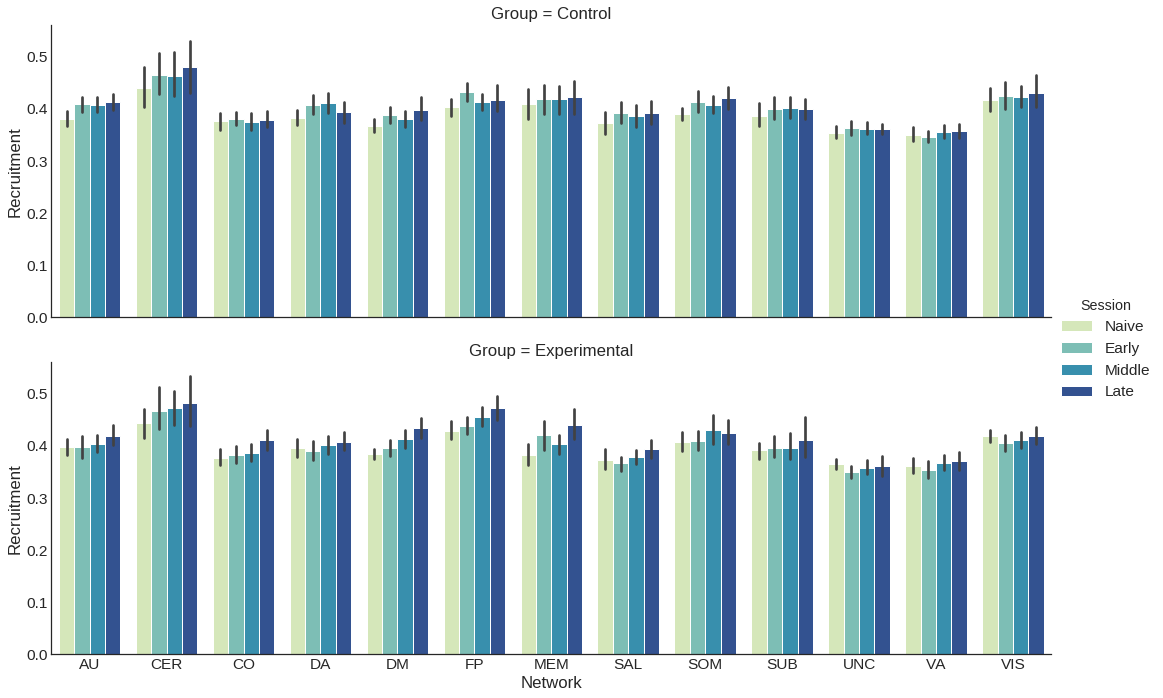

In [14]:
#--- calculate mean recruitment for each network
recr = pd.DataFrame()
subs = trained_subs.iloc[:,0].values

for i, sub in enumerate(subs):
    for j, ses in enumerate(ses_lab):
        diag_val = np.diag(NA[i, j, :, :])
        for k, elem in enumerate(diag_val):
            result = pd.DataFrame([[sub, ses, np.unique(modules)[k], elem]], 
                                  columns=['sub', 'Session', 'Network', 'Recruitment'])
            recr = pd.concat([recr, result], axis = 0)
            
#--- merge with pandas dataframe with group assignment
recr = pd.merge(trained_subs, recr, on="sub")
recr = recr.rename(index=str, columns={"group": "Group"})

#--- plot mean recruitments
plt.rcParams["axes.labelsize"] = 20
sns.set(font_scale = 1.4)
plt.style.use('seaborn-white')
g = sns.catplot(x="Network", y="Recruitment", hue="Session", kind="bar", row = 'Group', data=recr, height=5, aspect = 3, palette = "YlGnBu")

Calculate and plot mean DMN integration
----------------------------------------

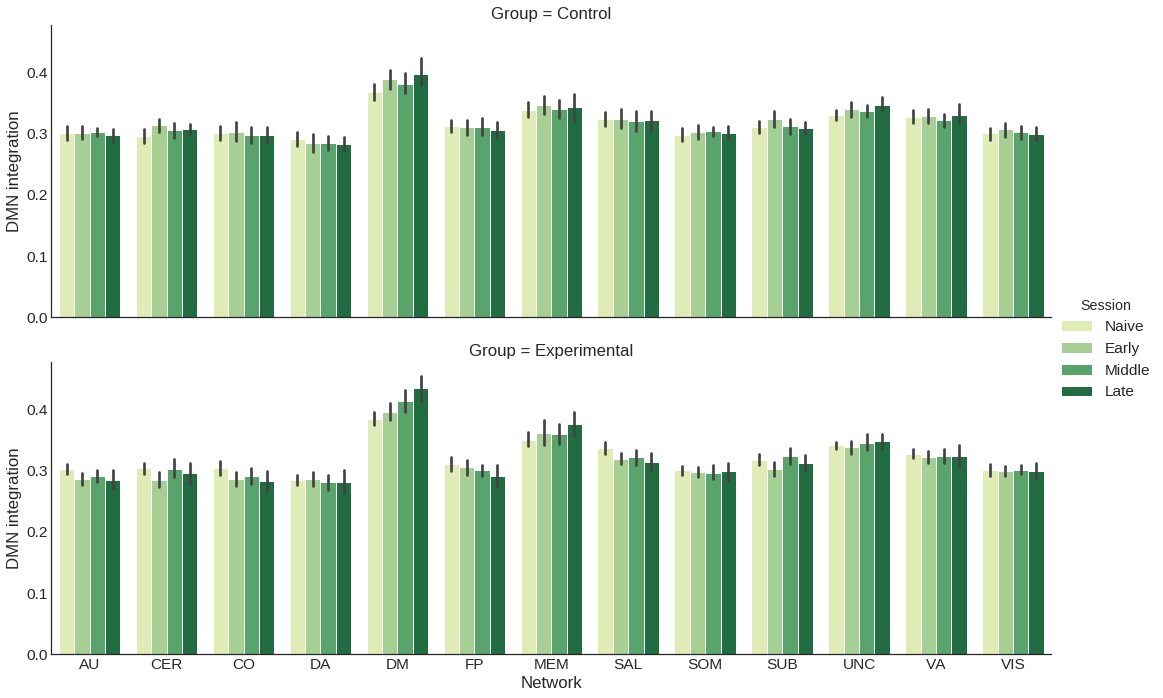

In [15]:
#--- calculate mean integration for each network

integ = pd.DataFrame()
subs = trained_subs.iloc[:,0].values

for i, sub in enumerate(subs):
    for j, ses in enumerate(ses_lab):
        for k, elem in enumerate(np.unique(modules)):
            dmn_integ = NA[i, j, 4, k]
            
            result = pd.DataFrame([[sub, ses, np.unique(modules)[k], dmn_integ]], 
                                  columns=['sub', 'Session', 'Network', 'DMN integration'])
            integ = pd.concat([integ, result], axis = 0)
            
#--- merge with pandas dataframe with group assignment
integ = pd.merge(trained_subs, integ, on="sub")
integ = integ.rename(index=str, columns={"group": "Group"})

#--- plot DMN integration
plt.rcParams["axes.labelsize"] = 20
sns.set(font_scale = 1.4)
plt.style.use('seaborn-white')
g = sns.catplot(x="Network", y="DMN integration", hue="Session", kind="bar", row = 'Group', data=integ, height=5, aspect = 3, palette = "YlGn")

Calculate slope of changes or allegiances within/between network
--------------------------------------------------------------------

In [21]:
#--- calculate slopes

xi = np.arange(1,5)
slopes = np.zeros((46,13,13))

for sub in range(46):
    for i in range(13):
        for j in range(13):
            vec = NA[sub,:,i,j]
            slope, intercept, r_value, p_value, std_err = stats.linregress(xi,vec)
            slopes[sub,i,j] = slope

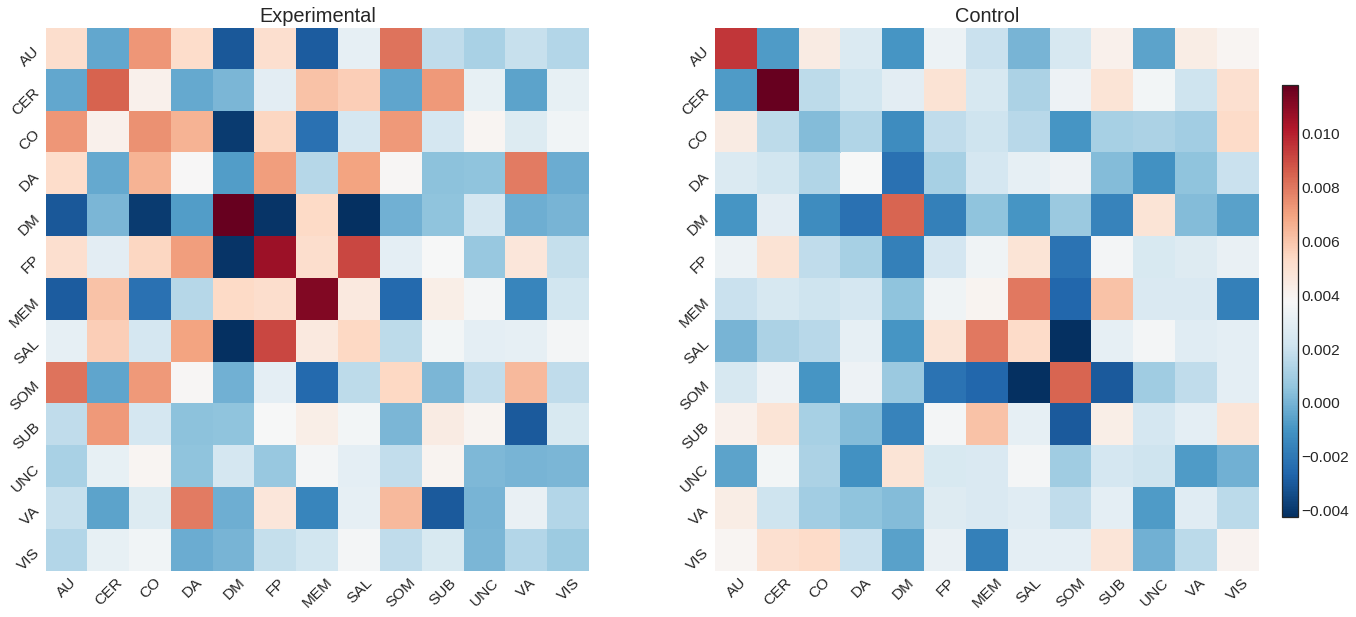

In [22]:
# plot slopes separately for each group

plt.style.use('seaborn-white')
fig.tight_layout
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(22, 10)
group_vectors = [exp_vector, con_vector]
group_lab = ['Experimental', 'Control']

for i, vec in enumerate(group_vectors):
    mean_slope = slopes[vec, :,:].mean(axis = 0)
    plt.ioff()
    g = sns.heatmap(mean_slope, yticklabels = np.unique(modules), 
                        xticklabels = np.unique(modules), 
                        square = True, 
                        cmap = "RdBu_r", 
                        ax=axes[i],
                        cbar=None)
    g.set_title(f'{group_lab[i]}', size = 20)
    g.set_xticklabels(np.unique(modules), rotation=45)
    g.set_yticklabels(np.unique(modules), rotation=45)

im = plt.gca().get_children()[0]
cax = fig.add_axes([.91, .2, .01, .6]) 
fig.colorbar(im, cax=cax, drawedges = False)


Behavioral-network correlations
---------------------------------------


In [23]:
#--- load dataframes with behavioral data

training = pd.read_csv("/home/finc/Dropbox/Projects/LearningBrain/data/behavioral/LB_training_summary.csv") #--- improvement in training
fmri_beh = pd.read_csv("/home/finc/Dropbox/Projects/LearningBrain/data/behavioral/LB_fmri_beh_slope.csv") #--- improvement in the scanner 
training.head()

,sub,nback_mean_estimate,nback_max_estimate,nback_baseline,nback_max_level
0,sub-05,0.084417,0.118679,2.05,6
1,sub-06,0.106656,0.169247,2.10,7
2,sub-07,0.003973,0.033024,2.30,5
3,sub-11,0.112074,0.137255,2.00,5
4,sub-14,0.051754,0.074303,2.10,4


In [24]:
fmri_beh.head()

,sub,Estimate,group
0,sub-01,0.096214,Control
1,sub-02,0.045777,Control
2,sub-04,0.038975,Control
3,sub-05,-0.016430,Experimental
4,sub-06,0.268154,Experimental


Plotting correlations with improvement measured during training (experimental group)
------------------------------------------------------------------

[Text(0,0.5,'AU'),
 Text(0,1.5,'CER'),
 Text(0,2.5,'CO'),
 Text(0,3.5,'DA'),
 Text(0,4.5,'DM'),
 Text(0,5.5,'FP'),
 Text(0,6.5,'MEM'),
 Text(0,7.5,'SAL'),
 Text(0,8.5,'SOM'),
 Text(0,9.5,'SUB'),
 Text(0,10.5,'UNC'),
 Text(0,11.5,'VA'),
 Text(0,12.5,'VIS')]

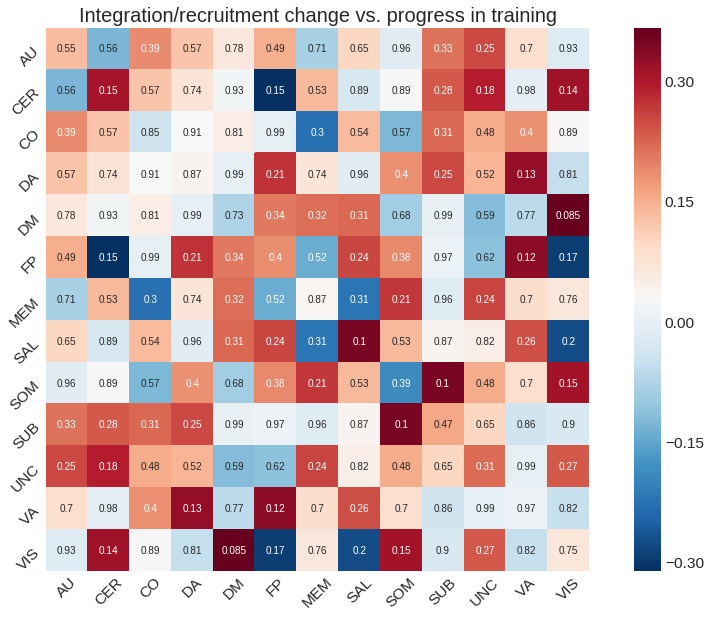

In [35]:
exp_slope = slopes[exp_vector, :,:]
correlations = np.zeros((13, 13))
pvals = np.zeros((13, 13))

for i in range(13):
    for j in range(13):
        corr, pval = stats.pearsonr(exp_slope[:,i, j], training['nback_max_estimate'].values)
        correlations[i,j] = corr
        pvals[i,j] = pval

fig = plt.gcf()
fig.set_size_inches( 16, 10)

g = sns.heatmap(correlations, yticklabels = np.unique(modules), 
                        xticklabels = np.unique(modules), 
                        square = True, 
                        cmap = "RdBu_r",
                        annot = pvals) 
plt.ioff()
g.set_title('Integration/recruitment change vs. progress in training', size = 20)
g.set_xticklabels(np.unique(modules), rotation=45)
g.set_yticklabels(np.unique(modules), rotation=45)

Plotting correlations with improvement measured fMRI testing (experimental group)
------------------------------------------------------------------

[Text(0,0.5,'AU'),
 Text(0,1.5,'CER'),
 Text(0,2.5,'CO'),
 Text(0,3.5,'DA'),
 Text(0,4.5,'DM'),
 Text(0,5.5,'FP'),
 Text(0,6.5,'MEM'),
 Text(0,7.5,'SAL'),
 Text(0,8.5,'SOM'),
 Text(0,9.5,'SUB'),
 Text(0,10.5,'UNC'),
 Text(0,11.5,'VA'),
 Text(0,12.5,'VIS')]

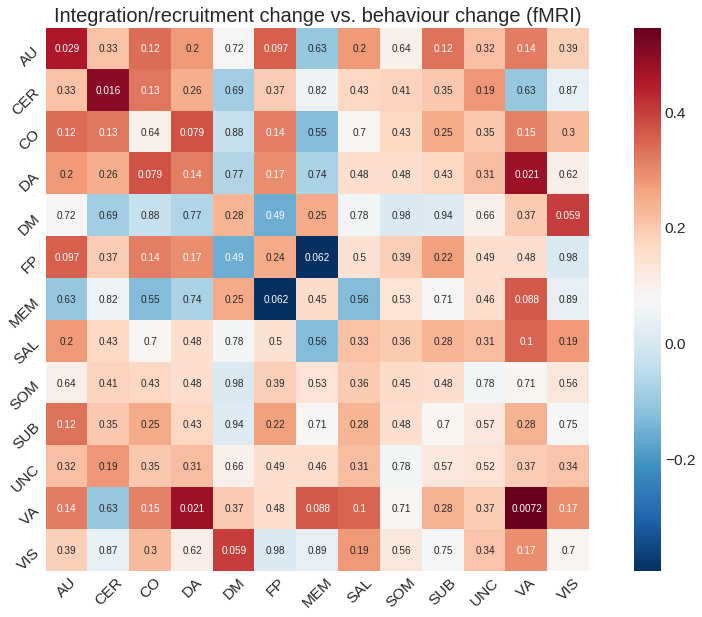

In [37]:
exp_perf = fmri_beh[fmri_beh.group == 'Experimental']
correlations = np.zeros((13, 13))
pvals = np.zeros((13, 13))

for i in range(13):
    for j in range(13):
        corr, pval = stats.pearsonr(exp_slope[:,i, j], exp_perf['Estimate'].values)
        correlations[i,j] = corr
        pvals[i,j] = pval
    
fig = plt.gcf()
fig.set_size_inches(16, 10)

g = sns.heatmap(correlations, yticklabels = np.unique(modules), 
                        xticklabels = np.unique(modules), 
                        square = True, 
                        cmap = "RdBu_r",
                        annot = pvals) 

g.set_title('Integration/recruitment change vs. behaviour change (fMRI)', size = 20)
g.set_xticklabels(np.unique(modules), rotation=45)
g.set_yticklabels(np.unique(modules), rotation=45)

Plotting correlations with improvement measured fMRI testing (all)
------------------------------------------------------------------

[Text(0,0.5,'AU'),
 Text(0,1.5,'CER'),
 Text(0,2.5,'CO'),
 Text(0,3.5,'DA'),
 Text(0,4.5,'DM'),
 Text(0,5.5,'FP'),
 Text(0,6.5,'MEM'),
 Text(0,7.5,'SAL'),
 Text(0,8.5,'SOM'),
 Text(0,9.5,'SUB'),
 Text(0,10.5,'UNC'),
 Text(0,11.5,'VA'),
 Text(0,12.5,'VIS')]

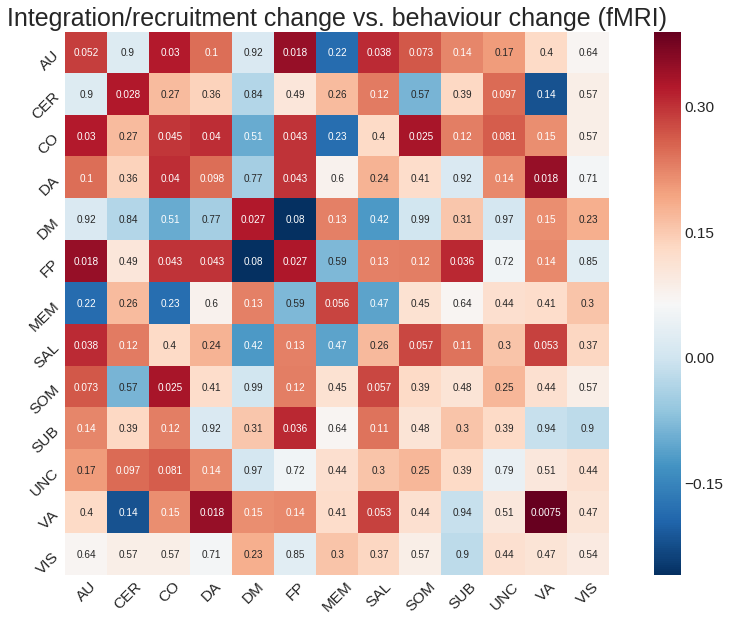

In [38]:
#slope_vec = sym_matrix_to_vec(slopes[:,:,:], discard_diagonal = False)

correlations = np.zeros((13, 13))
pvals = np.zeros((13, 13))

for i in range(13):
    for j in range(13):
        corr, pval = stats.pearsonr(slopes[:,i, j], fmri_beh['Estimate'].values)
        correlations[i,j] = corr
        pvals[i,j] = pval
    
fig = plt.gcf()
fig.set_size_inches(16, 10)

g = sns.heatmap(correlations, yticklabels = np.unique(modules), 
                        xticklabels = np.unique(modules), 
                        square = True, 
                        cmap = "RdBu_r",
                        annot = pvals) 

g.set_title('Integration/recruitment change vs. behaviour change (fMRI)', size = 25)
g.set_xticklabels(np.unique(modules), rotation=45)
g.set_yticklabels(np.unique(modules), rotation=45)

Creating pd dataframes for scatterplots
------------------------------------------

In [40]:
#--- recruitment

recr_slope = pd.DataFrame()
subs = trained_subs.iloc[:,0].values

for i, sub in enumerate(subs):        
    diag_val = np.diag(slopes[i, :, :])
    for k, elem in enumerate(diag_val):
        result = pd.DataFrame([[sub, np.unique(modules)[k], elem]], 
                                  columns=['sub', 'Network', 'Recruitment change'])
        recr_slope = pd.concat([recr_slope, result], axis = 0)
        
#--- DMN-FPN integration

DMN_inegr_slope = pd.DataFrame()#columns= np.unique(modules))

for i, sub in enumerate(subs):        
    val = slopes[i, 5, 4]
    result = pd.DataFrame([[sub, val]], columns=['sub', 'Integration change'])
    DMN_inegr_slope = pd.concat([DMN_inegr_slope, result], axis = 0)
    
beh_net_dmn = pd.merge(fmri_beh, DMN_inegr_slope , on = 'sub')
beh_net = pd.merge(fmri_beh, recr_slope, on = 'sub')

/home/finc/anaconda/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


Text(25,0.5,'DMN recruitment change')

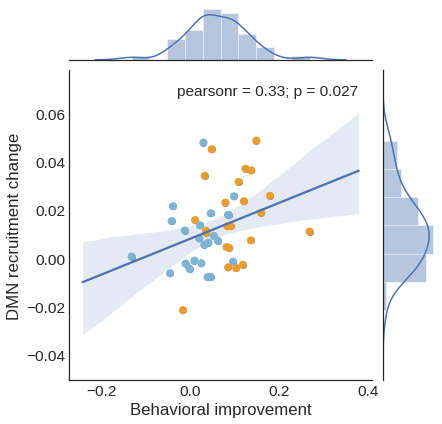

In [42]:
#--- setting colors for groups
groups_colors = {'Experimental':'#e99d2e', 'Control':'#7eb3d4'}
col = trained_subs.group.map(groups_colors)

lsn = 'DM'

g = sns.jointplot(x = 'Estimate', y = 'Recruitment change', data = beh_net[beh_net['Network'] == lsn], kind = 'reg', stat_func = stats.pearsonr)

g.plot_joint(plt.scatter, marker='o', c=col, s=50)

plt.xlabel('Behavioral improvement')
plt.ylabel(f'{lsn}N recruitment change')


/home/finc/anaconda/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


Text(25,0.5,'DMN integration change')

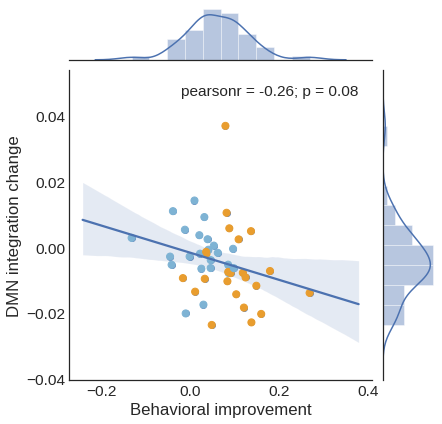

In [43]:
lsn = 'DM'

g = sns.jointplot(x = 'Estimate', y = 'Integration change', data = beh_net_dmn, kind = 'reg', stat_func = stats.pearsonr)
g.plot_joint(plt.scatter, marker='o', c=col, s=50)

plt.xlabel('Behavioral improvement')
plt.ylabel(f'{lsn}N integration change')


Testing
---------------

In [ ]:
for label in labels[0].unique():
    g.ax_col_dendrogram.bar(0, 0, color=network_lut[label],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=5)

In [ ]:
matrix_networks_plot

In [157]:
labels[0].unique()

array(['UNC', 'SOM', 'CO', 'AU', 'DM', 'MEM', 'VA', 'VIS', 'FP', 'SAL',
       'SUB', 'CER', 'DA'], dtype=object)

In [18]:
experimental = AM[exp_vector,:,:,:]

exp_sess = experimental.mean(axis = 0)

In [19]:
u = exp_sess[:,:,idx]
p = u[:,idx,:]

p.shape

(4, 264, 264)

In [20]:
control = AM[con_vector,:,:,:]
con_sess = control.mean(axis = 0)

r = con_sess[:,:,idx]
s = r[:,idx,:]

s.shape

(4, 264, 264)

In [21]:
experimental.shape

(23, 4, 264, 264)

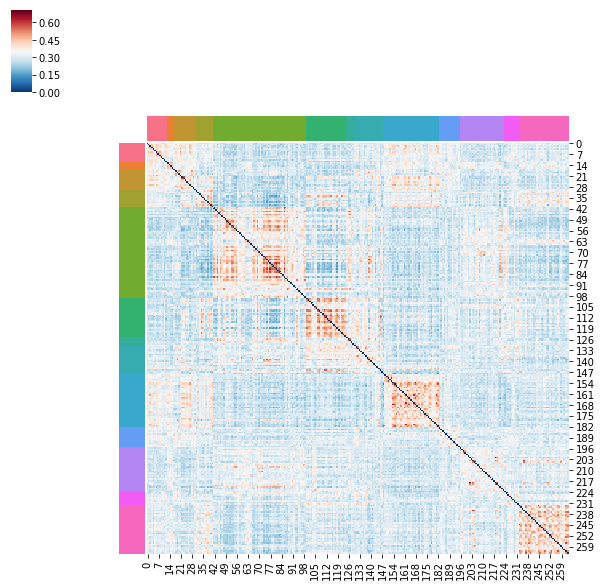

In [31]:
import seaborn as sns

sns.clustermap(p[0,:,:], cmap="RdBu_r",row_cluster=False, col_cluster=False,
               row_colors=network_colors, col_colors=network_colors)

In [32]:
mod = modules.reset_index(drop=True)

DMFP = (mod == 'DM')|(mod == 'FP')
DM = (mod == 'DM')
FP = (mod == 'FP')

sum(DMFP)

83

In [148]:
dmfp = e[:,:,DMFP,:]
dmfp = dmfp[:,:,:,DMFP] 
dmfp.shape


mean_dmfp = dmfp.mean(axis = 0)
mean_dmfp.shape

NameError: name 'e' is not defined

In [147]:
sns.clustermap(mean_dmfp[0,:,:], cmap="RdBu_r",row_cluster=False, col_cluster=False)

NameError: name 'mean_dmfp' is not defined

In [3]:
sns.clustermap(mean_dmfp[3,:,:], cmap="viridis",row_cluster=False, col_cluster=False)

NameError: name 'sns' is not defined

In [41]:
AMs = AM[:,:,idx,:]
AMsort = AMs[:,:,:,idx]

In [41]:
plotting.plot_matrix(c[0,:,:])

NameError: name 'c' is not defined

In [42]:
dm = AMsort[:,:,DM,:]
dm = dm[:,:,:,DM] 
dm.shape

mean_dm = dm.mean(axis = 2)
mean_dm = mean_dm.mean(axis = 2)

mean_dm.shape 
#mean_dm = dmp.mean(axis = 0)
#mean_dmfp.shape

mean_dm = pd.DataFrame(mean_dm)
mean_dm


,0,1,2,3
0,0.335553,0.369441,0.359929,0.356272
1,0.388763,0.395541,0.457015,0.331897
2,0.396730,0.438674,0.372384,0.397800
3,0.417747,0.364982,0.388080,0.401427
4,0.407402,0.408621,0.466617,0.403775
5,0.364477,0.405916,0.522562,0.445987
6,0.351011,0.353002,0.353954,0.348781
7,0.343371,0.452378,0.342985,0.358264
8,0.442479,0.373246,0.362128,0.500327
9,0.325803,0.360345,0.366677,0.368222


In [43]:
dm_i = AMsort[:,:,DM,:]
dm_i = dm_i[:,:,:,FP] 
dm_i.shape

mean_dm_i = dm_i.mean(axis = 2)
mean_dm_i = mean_dm_i.mean(axis = 2)

mean_dm_i.shape 
#mean_dm = dmp.mean(axis = 0)
#mean_dmfp.shape

mean_dm_i = pd.DataFrame(mean_dm_i)
mean_dm_i


,0,1,2,3
0,0.316931,0.285069,0.346586,0.279862
1,0.286690,0.279414,0.297966,0.272724
2,0.298207,0.271621,0.292069,0.285655
3,0.314069,0.300310,0.289621,0.325517
4,0.335621,0.327931,0.317103,0.308414
5,0.327759,0.277690,0.339966,0.280345
6,0.305862,0.309690,0.315517,0.309724
7,0.320172,0.246414,0.315517,0.303621
8,0.268862,0.264103,0.264759,0.242276
9,0.314517,0.326621,0.325345,0.284897


In [118]:
dm_i.shape

(23, 4, 58, 25)

In [91]:
AM.shape

(46, 4, 264, 264)

In [44]:
groups = pd.read_csv('/home/finc/Dropbox/Projects/LearningBrain/data/behavioral/group_assignment.csv')

trained = (groups.group == 'Experimental') | (groups.group == 'Control')
trained_subs = groups[trained]
trained_subs = trained_subs.reset_index(drop=True)

trained_subs


dmn_recruit = pd.concat([trained_subs, mean_dm], axis = 1)
dmn_integr = pd.concat([trained_subs, mean_dm_i], axis = 1)

In [45]:
dmn_recruit.to_csv(top_dir + 'dmn_recruit_new.csv', index=False)
dmn_integr.to_csv(top_dir + 'dmn_integr_new.csv', index=False)


In [123]:
dmn_integr

,sub,group,0,1,2,3
0,sub-01,Control,0.316103,0.332103,0.362828,0.304448
1,sub-02,Control,0.297862,0.303862,0.268586,0.288655
2,sub-04,Control,0.306931,0.288310,0.299103,0.311655
3,sub-05,Experimental,0.295552,0.334448,0.304724,0.274276
4,sub-06,Experimental,0.339483,0.343276,0.314207,0.302931
5,sub-07,Experimental,0.333103,0.302448,0.324759,0.295172
6,sub-08,Control,0.299138,0.317172,0.315517,0.309379
7,sub-10,Control,0.302483,0.284897,0.310690,0.324724
8,sub-11,Experimental,0.291241,0.274379,0.297207,0.259655
9,sub-12,Control,0.312138,0.349379,0.285828,0.307172


In [46]:
fp = AMsort[:,:,FP,:]
fp = fp[:,:,:,FP] 
fp.shape

mean_fp = fp.mean(axis = 2)
mean_fp = mean_fp.mean(axis = 2)

mean_fp.shape 
#mean_fp = fp.mean(axis = 0)
#mean_dmfp.shape

mean_fp = pd.DataFrame(mean_fp)
mean_fp

,0,1,2,3
0,0.38800,0.41120,0.37920,0.45440
1,0.41328,0.44768,0.41136,0.35136
2,0.37360,0.41584,0.37248,0.37024
3,0.40704,0.43792,0.37888,0.41456
4,0.38624,0.41616,0.49392,0.45824
5,0.46976,0.47376,0.43632,0.48432
6,0.33712,0.36048,0.35968,0.42720
7,0.38160,0.38928,0.33920,0.34416
8,0.41568,0.45296,0.38416,0.45440
9,0.37584,0.38544,0.36416,0.39568


In [47]:
fpn_recruit = pd.concat([trained_subs, mean_fp], axis = 1)
fpn_recruit.to_csv(top_dir + 'fpn_recruit_new.csv', index=False)
